In [6]:
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

from research.feature_engineering.data_loader import load_data
from research.feature_engineering.preprocess import add_mid_price
from research.feature_engineering.features import add_features
from research.feature_engineering.labels import add_label

df = load_data("data/raw/bank-nifty-1m-data.csv")
df = add_mid_price(df)
df = add_features(df)
df = add_label(df)
df = df.dropna()


In [7]:
features = ['ret1','ret5','vol10','vol30','pressure','trend_ratio']
X = df[features]
y = (df['y'] > 0).astype(int)


In [8]:
tscv = TimeSeriesSplit(n_splits=5)
aucs = []

for train, test in tscv.split(X):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    aucs.append(roc_auc_score(y_test, preds))

np.mean(aucs), aucs


(np.float64(0.6123725419491677),
 [0.6109245253718713,
  0.6114521591941112,
  0.6165029800491632,
  0.61752890226383,
  0.6054541428668629])

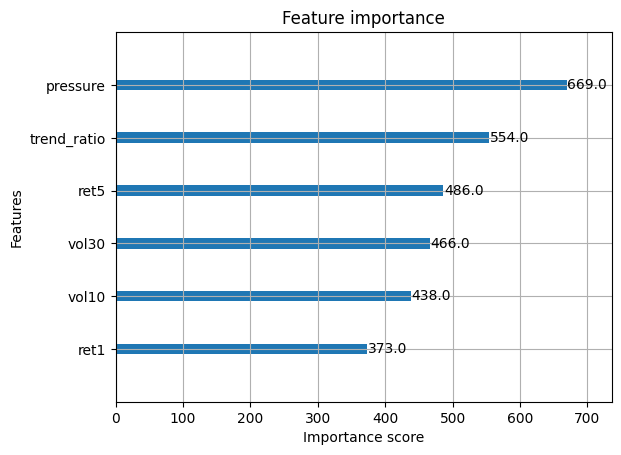

In [9]:
from xgboost import plot_importance
plot_importance(model)
plt.show()


In [10]:
import joblib
joblib.dump(model, "models/alpha_model.pkl")


['models/alpha_model.pkl']